# Introduction
In this programming assignment, we will learn to implement graph neural networks (GNNs) using the PyTorch-Geometric (PyG) package and apply it on a real-world data from Open Graph Benchmark (OGB) datasets to predict the properties of chemical molecules.

# Device
You might need to use a GPU for this Colab to run quickly. Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

In [1]:
import torch

In [2]:
torch.__version__

'1.10.0+cu111'

Download the necessary packages for PyG. Make sure that your version of torch matches the output from the cell above. In case of any issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 42.5 MB/s 
     |████████████████████████████████| 3.5 MB 48.3 MB/s 
     |████████████████████████████████| 2.5 MB 40.9 MB/s 
     |████████████████████████████████| 750 kB 45.6 MB/s 
     |████████████████████████████████| 407 kB 22.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=5ac7ec503f62b623bc0cec1b6163afdb99cf3fcec1489f06b9856ce9c438923c
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


Install the OGB dataset package

In [4]:
!pip install ogb

     |████████████████████████████████| 78 kB 4.8 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=5b4c1ded199cafed7e6b5b10abd704cca4fa2289be0d793d61a61f70f258a119
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


Import packages to use

In [6]:
import copy

from tqdm import tqdm
import pandas as pd

import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.utils import to_networkx

import networkx as nx

from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from ogb.graphproppred.mol_encoder import AtomEncoder

Now we are going to implement a Graph Convolutional Network (GCN) ([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)) using the PyG's built-in `GCNConv` layer. 

You can take a look at the [tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) of PyG.

The following figure gives an overview of our GCN model.
![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

The model consists of multiple blocks connected sequentially. In each block (except the last one), there are four layers:
1. a GCNConv layer
2. a BN (Batch Normalization) layer; Batch Normalization is a useful technique to make training (very) deep neural networks faster and more stable. It calculates the input data's mean and standard deviation and uses them to scale the data, making it match a standard distribution, therefore mitigate the instability between batches¹. Read the [docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for more information.
3. a ReLU activation layer
4. a dropout layer

The last block only has a GCNConv and a LogSoftmax layer.

Complete the implementation of the GCN model:

¹<small>The exact mechanism of batch normalization is still unclear. Search for more if interested.</small>

In [7]:
#from torch.nn.modules.batchnorm import BatchNorm1d
class GCN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                dropout=0.0, return_embeds=False):
    super(GCN, self).__init__()

    self.num_layers = num_layers
    ############# Your code here ############
    ## TODO: 
    ## Note:
    ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
    ##   - see https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
    ## 2. self.convs has num_layers GCNConv layers
    ## 3. self.bns has num_layers - 1 BatchNorm1d layers
    ## 4. You should use torch.nn.LogSoftmax for self.softmax
    ## 5. The parameters you can set for GCNConv include 'in_channels' and 
    ##   'out_channels'. For more information please refer to the documentation:
    ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
    ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
    ##   For more information please refer to the documentation: 
    ##   https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
    ## 7. You should use torch.nn.ReLU() for the activation layer
    ## 8. Initialize a dropout layer using torch.nn.Dropout
    ## (~10 lines of code)
    #self.convs= torch.nn.ModuleList()
    cn = []
    cn.append(GCNConv(input_dim,hidden_dim))
    for n in range(num_layers-2):
      cn.append(GCNConv(hidden_dim,hidden_dim))
    cn.append(GCNConv(hidden_dim,output_dim))
    self.convs = torch.nn.ModuleList(cn)
    #self.convs =  torch.nn.ModuleList([GCNConv(hidden_dim,hidden_dim) for i in range(num_layers-1)])
    bn = []
    #bn.append(torch.nn.modules.batchnorm.BatchNorm1d(num_features=input_dim))
    for n in range(num_layers-1):
      bn.append(torch.nn.modules.batchnorm.BatchNorm1d(num_features=hidden_dim))
    #bn.append(torch.nn.modules.batchnorm.BatchNorm1d(num_features=output_dim))
    #bn.append(BatchNorm1d(h))
    #self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(input_dim) for i in range(num_layers-1)])
    self.bns = torch.nn.ModuleList(bn)
    self.softmax = torch.nn.LogSoftmax()

    # activation layer
    self.activation =torch.nn.ReLU()

    # creat a dropout layer using the dropout rate
    self.dropout = torch.nn.Dropout(dropout)

    #########################################       

    # Skip classification layer and return node embeddings
    self.return_embeds = return_embeds

  def reset_parameters(self):
      for conv in self.convs:
          conv.reset_parameters()
      for bn in self.bns:
          bn.reset_parameters()

  def forward(self, x, edge_index):
      ############# Your code here ############
      ## TODO: Implement a function that takes the feature tensor x and
      ## edge_index tensor and returns the output tensor as
      ## shown in the figure.`
      ## Note:
      ## 1. Construct the network as shown in the figure
      ## 2. Note that there is no BN, activation, or dropout before the 
      ##   final output.
      ## 3. If return_embeds is True, then skip the last softmax layer
      ## (~10 lines of code)

      for i,k in enumerate(self.convs):
         x = self.convs[i](x,edge_index)
         if i != len(self.convs)-1:
          x = self.bns[i](x)
          x = self.activation(x)
          x = self.dropout(x)
          #x = self.softmax(x)
      if self.return_embeds==False:
        out=self.softmax(x)
      else:
        out=x

       

            





         

      #########################################

      return out

Test our model using toy data。 The output size should be [16, 8].

In [8]:
toy_x = torch.rand((16, 8))
toy_edge_index = torch.randint(0, 16, (2, 6))
toy_model = GCN(8, 8, 1, 5)
toy_y = toy_model(toy_x, toy_edge_index)
print(toy_y.size())

torch.Size([16, 1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Graph-level prediction

## The dataset

Here we use the moltox21 dataset and our task is to predict the properties of a molecular. Each input graph represents a molecule, where nodes are atoms, and edges are chemical bonds. This is a multiclass binary classification problem, which means that the output is a vector of 0 or 1, representing whether the molecule has a property.

In [9]:
TASKNAME = 'ogbg-moltox21'
dataset = PygGraphPropPredDataset(name=TASKNAME)

print('\n{} molecules in the dataset'.format(dataset.len()))

Downloaded 0.00 GB: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]
Processing...


Extracting dataset/tox21.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 7831/7831 [00:00<00:00, 107518.80it/s]


Converting graphs into PyG objects...


100%|██████████| 7831/7831 [00:00<00:00, 43469.32it/s]


Saving...

7831 molecules in the dataset


Done!


Let take a look at each input graph:

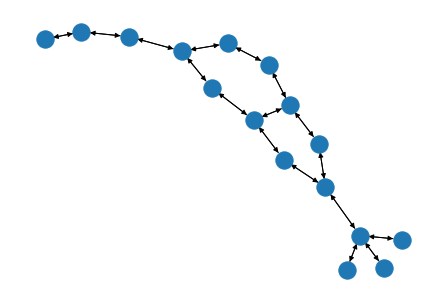

In [10]:
molecule0 = dataset.get(0)
nx.draw(to_networkx(molecule0))

Features of a node (atom) includes atomic number and chirality.

In [11]:
print('Molecule 0 has {} nodes (each with {} features);\n\
           and {} edges (each with {} features)\n'.format(
           molecule0.num_nodes,
           molecule0.num_node_features,
           molecule0.num_edges,
           molecule0.num_edge_features))

print('Node features for molecule 0:')
print(molecule0.x)

Molecule 0 has 16 nodes (each with 9 features);
           and 34 edges (each with 3 features)

Node features for molecule 0:
tensor([[ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 7,  0,  2,  5,  0,  0,  1,  0,  0],
        [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
        [ 6,  0,  2,  5,  0,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
        [15,  0,  4,  5,  0,  0,  2,  0,  0],
        [ 6,  0,  3,  5,  2,  0,  2,  0,  0],
        [ 7,  0,  1,  5,  0,  0,  1,  0,  0],
        [ 7,  0,  1,  5,  0,  0,  1,  0,  0],
        [15,  0,  2,  5,  0,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1]])


And this is what we want to predict (nan means unlabeled):

In [12]:
print('Label for molecule 0:')
print(molecule0.y)

Label for molecule 0:
tensor([[0., 0., 1., nan, nan, 0., 0., 1., 0., 0., 0., 0.]])


## Training

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

Device: cuda


In [14]:
split_idx = dataset.get_idx_split()

In [15]:
print('Task type: {}'.format(dataset.task_type))

Task type: binary classification


In [16]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

In [68]:
### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
  def __init__(self, hidden_dim, output_dim, num_layers, dropout):
    super(GCN_Graph, self).__init__()

    # Load encoders for Atoms in molecule graphs
    self.node_encoder = AtomEncoder(hidden_dim)

    # Node embedding model
    # Note that the input_dim and output_dim are set to hidden_dim
    self.gnn_node = GCN(hidden_dim, hidden_dim,
      hidden_dim, num_layers, dropout, return_embeds=True)


    ############# Your code here ############
    ## Note:
    ## 1. Initialize self.readout as a global mean pooling layer
    ## For more information please refer to the documentation:
    ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
    
    self.readout = global_mean_pool
    
    #########################################

    # Output layer
    self.linear = torch.nn.Linear(hidden_dim, output_dim)


  def reset_parameters(self):
    self.gnn_node.reset_parameters()
    self.linear.reset_parameters()

  def forward(self, batched_data):
    # TODO: Implement a function that takes as input a 
    # mini-batch of graphs (torch_geometric.data.Batch) and 
    # returns the predicted graph property for each graph. 
    #
    # NOTE: Since we are predicting graph level properties,
    # your output will be a tensor with dimension equaling
    # the number of graphs in the mini-batch


    # Extract important attributes of our mini-batch
    x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
    embed = self.node_encoder(x)

    ############# Your code here ############
    ## Note:
    ## 1. Construct node embeddings using existing GCN model
    ## 2. Use the global pooling layer to aggregate features for each individual graph
    ##   For more information please refer to the documentation:
    ##   https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
    ## 3. Use a linear layer to predict each graph's property
    ## (~3 lines of code)

    out = self.gnn_node(embed,edge_index)
    out = self.readout(out,batch)
    out = self.linear(out)
    #out=fcn(out)


    #########################################

    return out

In [69]:
def train(model, device, data_loader, optimizer, loss_fn):
  model.train()
  loss = 0

  for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
    batch = batch.to(device)

    if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
      pass
    else:
      ## ignore nan targets (unlabeled) when computing training loss.
      is_labeled = batch.y == batch.y
      optimizer.zero_grad()
      out = model(batch)
      loss = loss_fn(out[is_labeled], batch.y[is_labeled].type_as(out))
      loss.backward()
      optimizer.step()

  return loss.item()

In [70]:
# The evaluation function
def eval(model, device, loader, evaluator, save_model_results=False, save_file=None):
  model.eval()
  y_true = []
  y_pred = []

  for step, batch in enumerate(tqdm(loader, desc="Iteration")):
    batch = batch.to(device)

    if batch.x.shape[0] == 1:
      pass
    else:
      with torch.no_grad():
          pred = model(batch)

      y_true.append(batch.y.view(pred.shape).detach().cpu())
      y_pred.append(pred.detach().cpu())

  y_true = torch.cat(y_true, dim = 0).numpy()
  y_pred = torch.cat(y_pred, dim = 0).numpy()

  input_dict = {"y_true": y_true, "y_pred": y_pred}

  if save_model_results:
    print ("Saving Model Predictions")
    
    # Create a pandas dataframe with a two columns
    # y_pred | y_true
    data = {}
    data['y_pred'] = y_pred.reshape(-1)
    data['y_true'] = y_true.reshape(-1)

    df = pd.DataFrame(data=data)
    # Save to csv
    df.to_csv(f'{TASKNAME}_graph_' + save_file + '.csv', sep=',', index=False)

  return evaluator.eval(input_dict)

<a name='args_cell'></a> Define the hyper-parameters we are going to use:

In [75]:
######### You can change the hyper-parameters here ##########
args = {
  'device': device,
  'num_layers': 8,
  'hidden_dim': 128,
  'dropout': 0.2,
  'lr': 0.001,
  'epochs': 70,
}

In [77]:
model = GCN_Graph(args['hidden_dim'],
              dataset.num_tasks, args['num_layers'],
              args['dropout']).to(device)
evaluator = Evaluator(name=TASKNAME)

In [78]:
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  print('Training...')
  loss = train(model, device, train_loader, optimizer, loss_fn)

  print('Evaluating...')
  train_result = eval(model, device, train_loader, evaluator)
  val_result = eval(model, device, valid_loader, evaluator)
  test_result = eval(model, device, test_loader, evaluator)

  train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
  print(f'Epoch: {epoch:02d}, '
     f'Loss: {loss:.4f}, '
     f'Train: {100 * train_acc:.2f}%, '
     f'Valid: {100 * valid_acc:.2f}% '
     f'Test: {100 * test_acc:.2f}%')

Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.34it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.80it/s]


Epoch: 01, Loss: 0.2028, Train: 76.61%, Valid: 73.75% Test: 70.28%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.87it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.55it/s]


Epoch: 02, Loss: 0.3531, Train: 79.65%, Valid: 73.20% Test: 69.00%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.76it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.83it/s]


Epoch: 03, Loss: 0.1692, Train: 81.45%, Valid: 75.52% Test: 73.35%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.95it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 93.44it/s]


Epoch: 04, Loss: 0.2126, Train: 81.40%, Valid: 75.58% Test: 71.36%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.95it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 96.87it/s]


Epoch: 05, Loss: 0.1666, Train: 82.52%, Valid: 75.68% Test: 71.36%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.11it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.82it/s]


Epoch: 06, Loss: 0.1001, Train: 84.32%, Valid: 76.43% Test: 74.03%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.95it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.66it/s]


Epoch: 07, Loss: 0.1771, Train: 83.63%, Valid: 76.78% Test: 74.16%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.55it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.40it/s]


Epoch: 08, Loss: 0.1779, Train: 84.41%, Valid: 74.91% Test: 72.31%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 53.98it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 90.07it/s]


Epoch: 09, Loss: 0.3166, Train: 85.29%, Valid: 76.65% Test: 74.17%
Training...


Iteration: 100%|██████████| 196/196 [00:04<00:00, 41.61it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.72it/s]


Epoch: 10, Loss: 0.1257, Train: 84.87%, Valid: 76.17% Test: 73.90%
Training...


Iteration: 100%|██████████| 196/196 [00:04<00:00, 47.98it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.76it/s]


Epoch: 11, Loss: 0.1435, Train: 85.72%, Valid: 76.19% Test: 73.70%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.12it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 93.38it/s]


Epoch: 12, Loss: 0.2072, Train: 85.26%, Valid: 77.20% Test: 73.69%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.98it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.76it/s]


Epoch: 13, Loss: 0.1862, Train: 86.67%, Valid: 77.69% Test: 74.02%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.46it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.64it/s]


Epoch: 14, Loss: 0.3815, Train: 85.59%, Valid: 75.87% Test: 73.98%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.42it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.14it/s]


Epoch: 15, Loss: 0.2205, Train: 86.37%, Valid: 75.94% Test: 74.15%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.88it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.64it/s]


Epoch: 16, Loss: 0.1904, Train: 87.07%, Valid: 77.03% Test: 73.94%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.83it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 96.71it/s]


Epoch: 17, Loss: 0.1763, Train: 87.44%, Valid: 76.91% Test: 74.12%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.48it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.36it/s]


Epoch: 18, Loss: 0.0770, Train: 87.51%, Valid: 77.12% Test: 74.47%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.10it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 90.47it/s]


Epoch: 19, Loss: 0.2290, Train: 88.57%, Valid: 76.89% Test: 74.80%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.85it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 90.87it/s]


Epoch: 20, Loss: 0.1335, Train: 88.59%, Valid: 77.81% Test: 74.22%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.47it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 93.98it/s]


Epoch: 21, Loss: 0.1757, Train: 88.34%, Valid: 77.72% Test: 73.51%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.25it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 96.71it/s]


Epoch: 22, Loss: 0.2181, Train: 88.12%, Valid: 77.74% Test: 73.76%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.79it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.32it/s]


Epoch: 23, Loss: 0.0763, Train: 88.94%, Valid: 77.03% Test: 73.25%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.02it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.96it/s]


Epoch: 24, Loss: 0.2335, Train: 87.94%, Valid: 76.61% Test: 74.09%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.00it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.02it/s]


Epoch: 25, Loss: 0.1248, Train: 89.28%, Valid: 77.07% Test: 73.92%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.28it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 96.66it/s]


Epoch: 26, Loss: 0.1379, Train: 89.00%, Valid: 76.88% Test: 74.81%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.68it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.69it/s]


Epoch: 27, Loss: 0.1649, Train: 89.06%, Valid: 76.05% Test: 74.50%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.20it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 89.94it/s]


Epoch: 28, Loss: 0.0967, Train: 89.67%, Valid: 76.88% Test: 75.65%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.92it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.58it/s]


Epoch: 29, Loss: 0.1381, Train: 89.46%, Valid: 77.01% Test: 74.00%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.81it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.92it/s]


Epoch: 30, Loss: 0.1459, Train: 89.12%, Valid: 77.94% Test: 73.52%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 56.03it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.05it/s]


Epoch: 31, Loss: 0.2138, Train: 90.12%, Valid: 78.20% Test: 74.12%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.73it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.44it/s]


Epoch: 32, Loss: 0.1068, Train: 90.37%, Valid: 77.62% Test: 73.64%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.11it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.95it/s]


Epoch: 33, Loss: 0.2296, Train: 90.42%, Valid: 78.15% Test: 75.87%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.88it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 91.48it/s]


Epoch: 34, Loss: 0.2895, Train: 90.08%, Valid: 77.54% Test: 73.53%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 56.06it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.32it/s]


Epoch: 35, Loss: 0.1172, Train: 90.52%, Valid: 78.36% Test: 75.22%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 56.42it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 99.06it/s]


Epoch: 36, Loss: 0.1667, Train: 90.31%, Valid: 76.22% Test: 74.61%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.86it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.74it/s]


Epoch: 37, Loss: 0.1170, Train: 90.96%, Valid: 77.51% Test: 75.04%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.89it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.52it/s]


Epoch: 38, Loss: 0.1374, Train: 90.74%, Valid: 76.93% Test: 74.52%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.44it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.59it/s]


Epoch: 39, Loss: 0.2065, Train: 90.73%, Valid: 77.82% Test: 74.28%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 56.08it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.38it/s]


Epoch: 40, Loss: 0.1202, Train: 90.97%, Valid: 77.48% Test: 75.77%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.78it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.54it/s]


Epoch: 41, Loss: 0.1380, Train: 91.02%, Valid: 77.03% Test: 74.36%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 56.19it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.51it/s]


Epoch: 42, Loss: 0.1552, Train: 91.15%, Valid: 77.78% Test: 74.92%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.81it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.91it/s]


Epoch: 43, Loss: 0.1679, Train: 91.03%, Valid: 77.62% Test: 74.42%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.97it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.33it/s]


Epoch: 44, Loss: 0.1449, Train: 91.51%, Valid: 77.01% Test: 74.68%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.74it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.44it/s]


Epoch: 45, Loss: 0.1015, Train: 91.88%, Valid: 77.61% Test: 75.27%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.39it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.85it/s]


Epoch: 46, Loss: 0.2205, Train: 91.44%, Valid: 77.17% Test: 74.66%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 56.02it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.25it/s]


Epoch: 47, Loss: 0.0699, Train: 92.02%, Valid: 77.22% Test: 74.64%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.09it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.15it/s]


Epoch: 48, Loss: 0.1170, Train: 91.79%, Valid: 77.29% Test: 74.75%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.59it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.92it/s]


Epoch: 49, Loss: 0.0781, Train: 92.01%, Valid: 77.21% Test: 74.19%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.37it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 96.01it/s]


Epoch: 50, Loss: 0.1660, Train: 92.11%, Valid: 77.25% Test: 74.94%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.68it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.05it/s]


Epoch: 51, Loss: 0.1232, Train: 92.44%, Valid: 76.90% Test: 73.91%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.69it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 89.68it/s]


Epoch: 52, Loss: 0.1503, Train: 92.42%, Valid: 76.95% Test: 74.75%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.77it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 93.00it/s]


Epoch: 53, Loss: 0.1415, Train: 92.55%, Valid: 77.77% Test: 75.15%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.02it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 96.61it/s]


Epoch: 54, Loss: 0.1338, Train: 92.67%, Valid: 76.45% Test: 74.67%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.65it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.38it/s]


Epoch: 55, Loss: 0.1547, Train: 92.67%, Valid: 77.46% Test: 75.12%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.50it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.20it/s]


Epoch: 56, Loss: 0.0906, Train: 92.68%, Valid: 76.98% Test: 74.73%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.47it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 93.34it/s]


Epoch: 57, Loss: 0.2671, Train: 92.52%, Valid: 78.14% Test: 74.94%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.65it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.20it/s]


Epoch: 58, Loss: 0.1111, Train: 92.96%, Valid: 78.19% Test: 74.64%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.95it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.48it/s]


Epoch: 59, Loss: 0.1551, Train: 92.65%, Valid: 76.15% Test: 74.31%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.85it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 91.39it/s]


Epoch: 60, Loss: 0.1344, Train: 93.03%, Valid: 77.71% Test: 74.47%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.79it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 93.91it/s]


Epoch: 61, Loss: 0.1012, Train: 93.10%, Valid: 77.83% Test: 75.17%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.81it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 93.87it/s]


Epoch: 62, Loss: 0.1302, Train: 92.76%, Valid: 77.69% Test: 75.03%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.80it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.63it/s]


Epoch: 63, Loss: 0.1053, Train: 93.40%, Valid: 77.50% Test: 75.33%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.93it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.32it/s]


Epoch: 64, Loss: 0.1639, Train: 93.18%, Valid: 77.16% Test: 75.07%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 56.27it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.97it/s]


Epoch: 65, Loss: 0.1476, Train: 93.15%, Valid: 77.64% Test: 74.76%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.17it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 96.58it/s]


Epoch: 66, Loss: 0.1969, Train: 93.22%, Valid: 77.84% Test: 75.10%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.76it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 92.06it/s]


Epoch: 67, Loss: 0.1063, Train: 93.40%, Valid: 76.55% Test: 75.36%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 54.85it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 94.84it/s]


Epoch: 68, Loss: 0.1254, Train: 93.63%, Valid: 77.56% Test: 75.37%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.97it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 97.20it/s]


Epoch: 69, Loss: 0.1576, Train: 93.40%, Valid: 78.31% Test: 74.25%
Training...


Iteration: 100%|██████████| 196/196 [00:03<00:00, 55.57it/s]


Evaluating...


Iteration: 100%|██████████| 25/25 [00:00<00:00, 95.92it/s]

Epoch: 70, Loss: 0.1214, Train: 93.33%, Valid: 77.08% Test: 75.29%


## Evaluation

In [79]:
train_acc = eval(best_model, device, train_loader, evaluator)[dataset.eval_metric]
valid_acc = eval(best_model, device, valid_loader, evaluator)[dataset.eval_metric]
test_acc = eval(best_model, device, test_loader, evaluator, save_model_results=True, save_file="test")[dataset.eval_metric]

print(f'Best model: '
   f'Train: {100 * train_acc:.2f}%, '
   f'Valid: {100 * valid_acc:.2f}% '
   f'Test: {100 * test_acc:.2f}%')

Iteration: 100%|██████████| 25/25 [00:00<00:00, 96.05it/s]

Saving Model Predictions
Best model: Train: 90.52%, Valid: 78.36% Test: 75.22%


# Submission

The default hyper-parameters are not optimal.
Play with the hyper-parameters in the [`args` dictionary](#args_cell) to achieve better performance, like what we did in previous assignments.

During the evaluation, the predicted labels for the test dataset have been saved to a csv file by setting `save_model_results=True`. Once you finished training the model, click the "files" button in the sidebar and download the `ogbg-moltox21_graph_test.csv` file.

**Submit the `.ipynb` file and the `.csv` file to gradescope.** To prevent failing the autograder accidentally,
- Don't change the filenames.
- Don't add/remove cells in this notebook.
- Don't change the existing skeleton code.